In [244]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import TextVectorization, Embedding, Bidirectional, LSTM, SpatialDropout1D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.data import Dataset

In [245]:
df_dev = pd.read_csv("dataset\subtaskA_clean_dev_cased.csv")
df_dev.head()

,comment_text,conspiratorial
0,Se non ci fossero soldati non ci sarebbero gue...,0
1,"]( ""Shedding of Infectious SARS-CoV-2 Des...",1
2,PAURA E DELIRIO ALLA CNN: IL MINISTERO DELLA V...,1
3,L'Aspirina non aumenta la sopravvivenza dei pa...,0
4,L'Italia non puo' dare armi lo vieta la Costit...,0


In [246]:
df_dev.shape

(1840, 2)

In [247]:
X_dev = list(df_dev.comment_text) # lista di stringhe

In [248]:
y_dev = list(df_dev.conspiratorial)

# Data Splitting

In [249]:
# Extract a training & validation split
validation_split = 0.3
num_validation_samples = int(validation_split * len(X_dev))
num_validation_samples

552

In [250]:
X_train = X_dev[:-num_validation_samples]
len(X_train)

1288

In [251]:
X_val = X_dev[-num_validation_samples:]
len(X_val)

552

In [252]:
y_train = y_dev[:-num_validation_samples]
len(y_train)

1288

In [253]:
y_val = y_dev[-num_validation_samples:]
len(y_val)

552

# Text Vectorization

In [255]:
max_lenght = 705 # n° massimo di token contenuti in un post del dev, scoperto tramite un preprocessing preliminare

In [338]:
vectorize_layer = TextVectorization(max_tokens=20000, # Max vocabulary size (to specifiy when adapting a vocabulary)
                                    output_sequence_length=max_lenght) # output dim padded or truncated => tensor of shape (batch_size, output_sequence_length)
text_ds = Dataset.from_tensor_slices(X_train)
text_ds

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [339]:
(list(text_ds.as_numpy_iterator()))[0]

b'Se non ci fossero soldati non ci sarebbero guerre.'

text_ds contiene tutti i post, ogni post è di tipo bytes.

In [340]:
vectorize_layer.adapt(text_ds.batch(64))

In [341]:
vectorize_layer.get_vocabulary()[:15]

['',
 '[UNK]',
 'di',
 'e',
 'che',
 'il',
 'la',
 'in',
 'non',
 'a',
 'per',
 'i',
 'è',
 'del',
 'un']

In [342]:
vocabulary = vectorize_layer.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))
len(vocabulary)

12379

## Word Embeddings

In [343]:
embeddings_path = '..\..\itwac128.txt'

In [51]:
def load_word_embeddings(emb_path):
    '''crea un dizionario contenente gli embedding di parole presente nel file src_path'''
    embeddings = dict() # dizionario che conterrà gli embedding
    for line in open(emb_path, 'r'):
        line = line.strip().split('\t')
        word = line[0]
        embedding = line[1:]
        embedding = [float(comp) for comp in embedding] # convertiamo le componenti dell'embedding in float
        embeddings[word] = np.asarray(embedding) # trasformiamo la lista delle componenti in un vettore di numpy
    return embeddings

In [52]:
embeddings = load_word_embeddings(embeddings_path)

In [53]:
len(embeddings)

1247492

### Creazione di una matrice di embeddings

Now, let's prepare a corresponding embedding matrix that we can use in a Keras Embedding layer. It's a simple NumPy matrix where entry at index i is the embedding for the word of index i in our vectorizer's vocabulary.

In [317]:
len(vocabulary)

12379

In [345]:
def embedding_init(shape, dtype):
    num_tokens = shape[0]
    embedding_dim = shape[1]
    #num_tokens = len(vocabulary) + 2
    #embedding_dim = 128
    hits = 0
    misses = 0
    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    # print("Converted %d words (%d misses)" % (hits, misses))
    return embedding_matrix

# Model Building

In [346]:
from tensorflow.keras import Input

In [405]:
x_train = vectorize_layer(np.array([[s] for s in X_train])).numpy()
x_val = vectorize_layer(np.array([[s] for s in X_val])).numpy()

y_train = np.array(y_train)
y_val = np.array(y_val)

In [406]:
model = Sequential()
# Start by creating an explicit input layer. It needs to have a shape of (1,) (because we need to guarantee that
# there is exactly one string input per batch), and the dtype needs to be 'string'.
#model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
# The first layer in our model is the vectorization layer. After this layer, we have a tensor of shape
# (batch_size, max_len) containing vocab indices.
#model.add(vectorize_layer)

Now, the model can map strings to integers, and you can add an embedding layer to map these integers to learned embeddings.

Embedding Layer Arguments

* input_dim: Integer. Size of the vocabulary, i.e. maximum integer index + 1.
* output_dim: Integer. Dimension of the dense embedding.
* embeddings_initializer: Initializer for the embeddings matrix (see keras.initializers).
* embeddings_regularizer: Regularizer function applied to the embeddings matrix (see keras.regularizers).
* embeddings_constraint: Constraint function applied to the embeddings matrix (see keras.constraints).
* mask_zero: Boolean, whether or not the input value 0 is a special "padding" value that should be masked out. This is useful when using recurrent layers which may take variable length input. If this is True, then all subsequent layers in the model need to support masking or an exception will be raised. If mask_zero is set to True, as a consequence, index 0 cannot be used in the vocabulary (input_dim should equal size of vocabulary + 1).
* input_length: Length of input sequences, when it is constant. This argument is required if you are going to connect Flatten then Dense layers upstream (without it, the shape of the dense outputs cannot be computed).
* sparse: If True, calling this layer returns a tf.SparseTensor. If False, the layer returns a dense tf.Tensor. For an entry with no features in a sparse tensor (entry with value 0), the embedding vector of index 0 is returned by default.

In [395]:
embedding_matrix.shape

(12381, 128)

In [407]:
# >>> model.add(tf.keras.layers.Embedding(1000, 64, input_length=10))
# The model will take as input an integer matrix of size (batch, input_length), and the largest integer (i.e.
# word index) in the input should be no larger than 999 (vocabulary size).
# Now model.output_shape is (None, 10, 64), where `None` is the batch dimension.
model.add(Embedding(
    input_dim = len(vocabulary),
    output_dim = embedding_dim,
    embeddings_initializer=embedding_init,
    input_length=705)) 
    #mask_zero=True)) # 0-padding should be masked out

LSTM arguments:
* units: Positive integer, dimensionality of the output space.
* activation: Activation function to use. Default: hyperbolic tangent (tanh). If you pass None, no activation is applied (ie. "linear" activation: a(x) = x).
* recurrent_activation: Activation function to use for the recurrent step. Default: sigmoid (sigmoid). If you pass None, no activation is applied (ie. "linear" activation: a(x) = x).

In [408]:
RNN_HIDDEN_SIZE = 25

In [409]:
model.add(LSTM(RNN_HIDDEN_SIZE))
model.add(Dense(50))

In [410]:
model.add(Dense(2, activation='softmax'))

In [411]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 705, 128)          1584512   
                                                                 
 lstm_16 (LSTM)              (None, 25)                15400     
                                                                 
 dense_19 (Dense)            (None, 50)                1300      
                                                                 
 dense_20 (Dense)            (None, 2)                 102       
                                                                 
Total params: 1,601,314
Trainable params: 1,601,314
Non-trainable params: 0
_________________________________________________________________


In [401]:
# plot_model(model, show_shapes=True)

In [414]:
from tensorflow.keras.optimizers import Adam
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [415]:
x_train.shape

(1288, 705)

In [416]:
history = model.fit(x_train, y_train, epochs=4, validation_data=(x_val, y_val))

Epoch 1/4
41/41 [==============================] - 22s 466ms/step - loss: 0.6944 - accuracy: 0.5116 - val_loss: 0.6944 - val_accuracy: 0.4710
Epoch 2/4
41/41 [==============================] - 26s 632ms/step - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.6921 - val_accuracy: 0.5290
Epoch 3/4
41/41 [==============================] - 26s 627ms/step - loss: 0.6938 - accuracy: 0.4884 - val_loss: 0.6995 - val_accuracy: 0.4710
Epoch 4/4
41/41 [==============================] - 18s 432ms/step - loss: 0.6929 - accuracy: 0.5085 - val_loss: 0.6939 - val_accuracy: 0.4710


In [359]:
history = model.history

In [417]:
import matplotlib.pyplot as plt

In [418]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

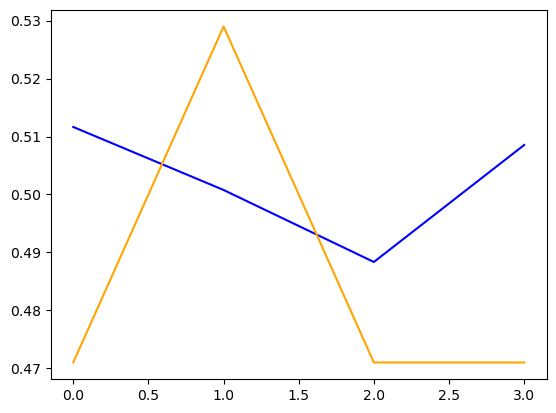

In [419]:
plt.plot(history.history['accuracy'], color='blue')
plt.plot(history.history['val_accuracy'], color='orange')
plt.show()

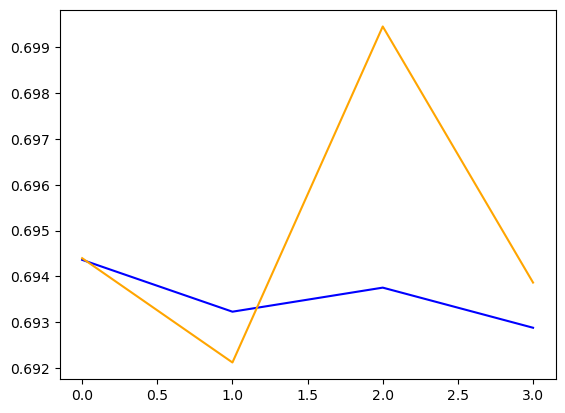

In [420]:
plt.plot(history.history['loss'], color='blue')
plt.plot(history.history['val_loss'], color='orange')
plt.show()

https://keras.io/examples/nlp/pretrained_word_embeddings/